# NLP (Natural Language Processing) - Project 2

In this NLP project we will attempt to classify Yelp Reviews into 1 star or 5 star categories based off the text content in the reviews. 

We will use the [Yelp Review Data Set from Kaggle](https://www.kaggle.com/c/yelp-recsys-2013).

Each observation in this dataset is a review of a particular business by a particular user.

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

## Imports

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from os import path
import sys
sys.path.append(path.abspath('../Functions'))

size=15
params = {'legend.fontsize': 'large',
          'figure.figsize': (20,8),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size*0.75,
          'ytick.labelsize': size*0.75,
          'axes.titlepad': 25}
plt.rcParams.update(params)

## The Dataset

In [3]:
yelp = pd.read_csv('yelp.csv')

In [4]:
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [5]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.4+ KB


In [7]:
yelp.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
stars,10000.0,3.7775,1.214636,1.0,3.0,4.0,5.0,5.0
cool,10000.0,0.8768,2.067861,0.0,0.0,0.0,1.0,77.0
useful,10000.0,1.4093,2.336647,0.0,0.0,1.0,2.0,76.0
funny,10000.0,0.7013,1.907942,0.0,0.0,0.0,1.0,57.0


We have 10 thousand entries, the mean number of stars is 3.77 with maximum being 5 and minimum being 1. 
The maximum number of "cools" for a review is 77, for "useful" is 76 and for "funny" is 57.

One of the features of the dataset is the "text", where the user can write a short review. We can check the length of each review and create a column for this new feature.

In [8]:
yelp['text length'] = yelp['text'].apply(len)
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0,76
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469


In [10]:
yelp['text length'].describe()

count    10000.000000
mean       710.738700
std        617.399827
min          1.000000
25%        294.000000
50%        541.500000
75%        930.000000
max       4997.000000
Name: text length, dtype: float64

The mean length is 710, with a high standard deviation (617). The minimum length is 1 and the maximum 4997!
Let's check this huge review.

In [14]:
yelp[yelp['text length'] == 4997]['text'].iloc[0]

'In our continuing quest to identify cool, locally owned places to eat and/or drink, Caroline and I auditioned Vintage 95 last night. \n\nBefore I go further, understand that whenever I go out for eats or drinks, I have  in  mind a Platonic Ideal of the Bar/Pub/Eatery I most want to frequent. I\'m on a constant quest to find that  Ideal expressed in Real Life. \n\nVintage 95 isn\'t quite there, but it\'s damn close. If I ever give something Five Stars, you\'ll know it has pegged my Platonic Ideal. Anyway...\n\nThe plan last night was for drinks. No plans for food, just Adult Beverages and warm conversation. But it turned into more.\n\nThe location in downtown Chandler is terrific for us. The owners have created a very fine visual experience - leather, stone, dark woods, good lighting. And they don\'t have the music turned up so loud that you CANNOT HAVE A CONVERSATION. This is one of my pet peeves. If I want to stare at people move their mouths while enduring an aural assault, I\'ll st

In [15]:
yelp[yelp['text length'] == 4997]['date'].iloc[0]

'2012-01-14'

In [17]:
yelp[yelp['text length'] == 4997]['stars'].iloc[0]

4

In [22]:
yelp[yelp['text length'] == 4997]['useful'].iloc[0]

1

Only 1 user found this review useful.

## Exploratory Data Analysis

In [23]:
yelp.columns

Index(['business_id', 'date', 'review_id', 'stars', 'text', 'type', 'user_id',
       'cool', 'useful', 'funny', 'text length'],
      dtype='object')

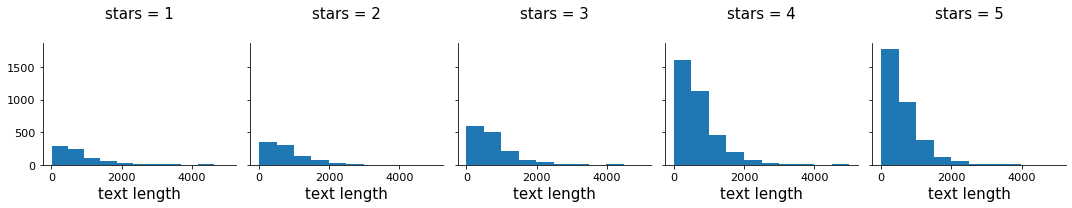

In [25]:
g = sns.FacetGrid(yelp,col='stars')
g.map(plt.hist,'text length');

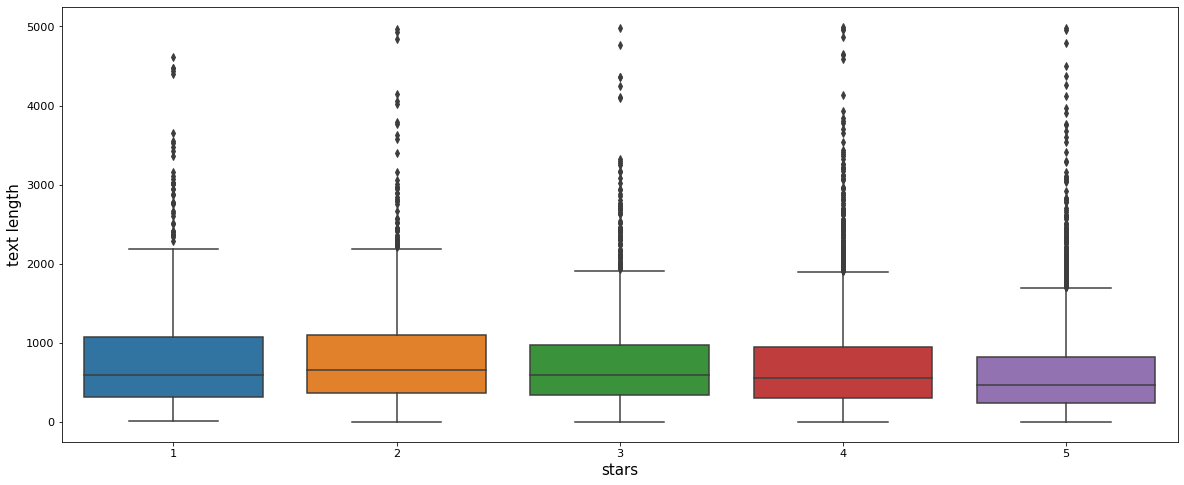

In [26]:
sns.boxplot(x='stars', y='text length',data=yelp);

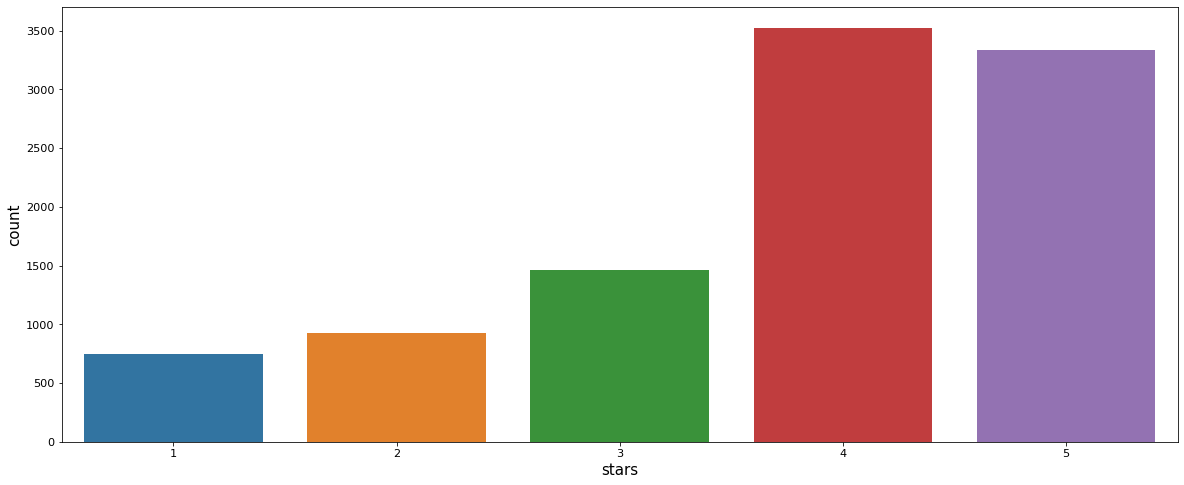

In [27]:
sns.countplot(x='stars',data=yelp);

In [28]:
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [29]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


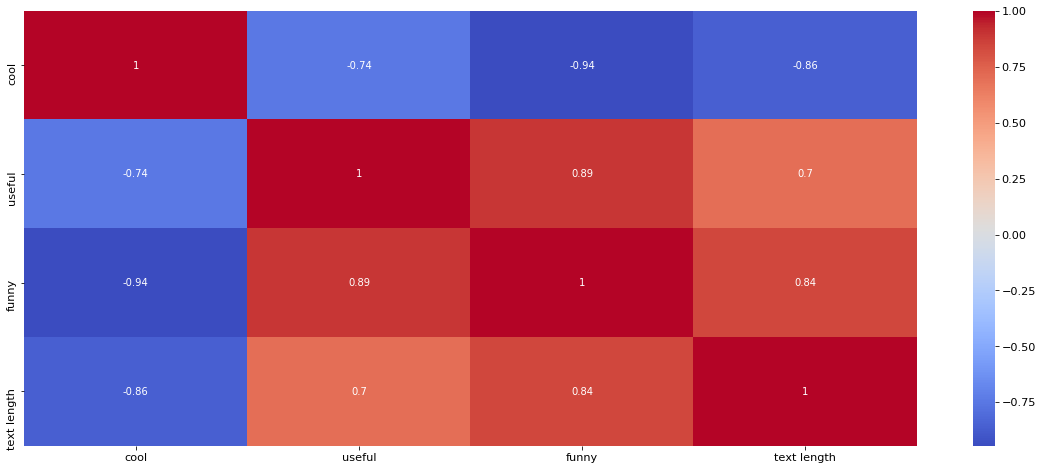

In [30]:
sns.heatmap(stars.corr(),cmap='coolwarm',annot=True);

## NLP Classification Task

Let's grab reviews that were either 1 star or 5 stars.

In [31]:
yelp_class = yelp[(yelp.stars==1) | (yelp.stars==5)]
yelp_class.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny,text length
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0,889
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0,1345
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0,419
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0,469
6,zp713qNhx8d9KCJJnrw1xA,2010-02-12,riFQ3vxNpP4rWLk_CSri2A,5,Drop what you're doing and drive here. After I...,review,wFweIWhv2fREZV_dYkz_1g,7,7,4,1565


In [32]:
X = yelp_class['text']
y = yelp_class['stars']

In [33]:
from sklearn.feature_extraction.text import CountVectorizer

In [34]:
cv = CountVectorizer()
X = cv.fit_transform(X)

## Train Test Split

In [35]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=101)

## Training a Model

In [37]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [38]:
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

## Predictions and Evaluations

In [39]:
prediction = nb.predict(X_test)

In [41]:
from sklearn.metrics import confusion_matrix, classification_report
from smc import show_confusion_matrix

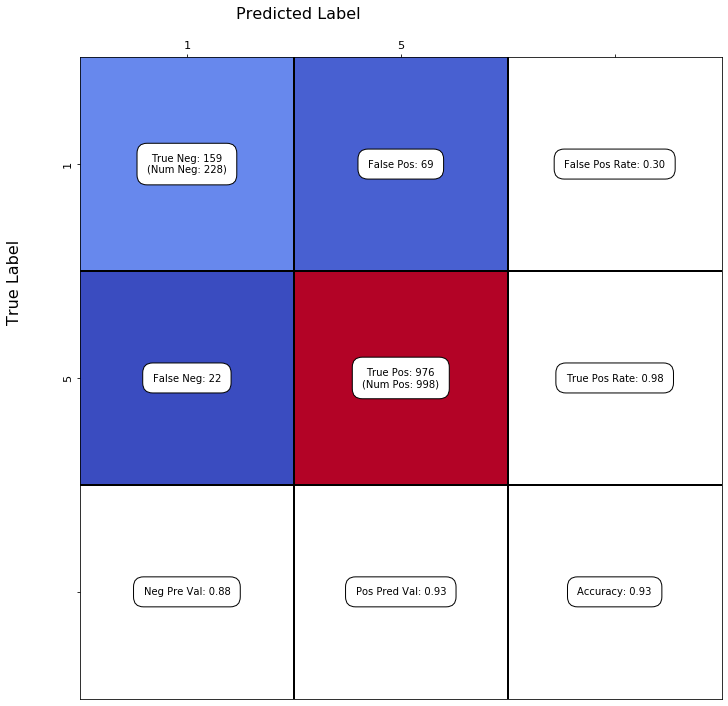

In [44]:
C = confusion_matrix(y_test,prediction)
show_confusion_matrix(C,['1','5'])

In [43]:
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           1       0.88      0.70      0.78       228
           5       0.93      0.98      0.96       998

    accuracy                           0.93      1226
   macro avg       0.91      0.84      0.87      1226
weighted avg       0.92      0.93      0.92      1226

